In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
seg_model = YOLO("yolov8n-seg.pt")

In [3]:
res = seg_model("./assets/dog1.jpeg", conf=0.5, show=False)

/opt/anaconda3/envs/llmenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


image 1/1 /Users/mehergajula/Desktop/Acads/Sem 4/dip/Project/assets/dog1.jpeg: 640x640 1 dog, 90.5ms
Speed: 4.0ms preprocess, 90.5ms inference, 603.6ms postprocess per image at shape (1, 3, 640, 640)


In [5]:
for r in res:
    img = np.copy(r.orig_img)
    img_name = Path(r.path).stem  # source image base-name

    # Iterate each object contour (multiple detections)
    for ci, c in enumerate(r):
        #  Get detection class name
        label = c.names[c.boxes.cls.tolist().pop()]

In [6]:
# Create binary mask
b_mask = np.zeros(img.shape[:2], np.uint8)

#  Extract contour result
contour = c.masks.xy.pop()
#  Changing the type
contour = contour.astype(np.int32)
#  Reshaping
contour = contour.reshape(-1, 1, 2)


# Draw contour onto mask
_ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

In [7]:
# Create 3-channel mask
mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)

# Isolate object with binary mask
isolated = cv2.bitwise_and(mask3ch, img)

In [36]:
isolated.shape

(1197, 1200, 3)

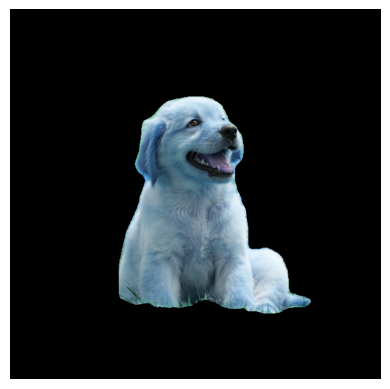

In [37]:
plt.imshow(isolated)
plt.axis("off")  # Turn off axis
plt.show()

In [38]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import requests
import torch

# Load Mask2Former trained on COCO instance segmentation dataset
image_processor = AutoImageProcessor.from_pretrained(
    "facebook/mask2former-swin-small-coco-instance"
)
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-small-coco-instance"
)

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# Model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# Perform post-processing to get instance segmentation map
pred_instance_map = image_processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]
print(pred_instance_map.shape)

torch.Size([480, 640])


: 